# Libraries Import

In [57]:
import random
import os
import time
import itertools
import copy

import pandas as pd
import numpy as np

## PyTorch
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.tensorboard import SummaryWriter
import torcheval.metrics as tm

## TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

## Sklearn
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

from sklearn import preprocessing, decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

## Saving, Loading and Plotting
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Var Selection

In [101]:
SEED = 42
FILENAME = "train_dataset.csv"

clf = 'rf'          # 'rf', 'svm', 'knn', 'ffnn', 'tabtansf' or 'tabnet'
pre = 'lda'         # 'pca', 'lda' or 'std'
overfit = True      # True or False

ml = True           # DON'T CHANGE (True for Machine Learning, False for Deep Learning)

if clf == 'ffnn' or clf == 'tabnet' or clf == 'tabtransf':
    overfit = True
    ml = False

In [102]:
if not ml:
    if torch.cuda.is_available():
        device = torch.device('cuda')

        torch.backends.cuda.enable_mem_efficient_sdp(False)
        torch.backends.cuda.enable_flash_sdp(False)
        torch.backends.cuda.enable_math_sdp(True)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        
    print("Device: {}".format(device))

In [103]:
if not ml:
    def fix_random(seed: int) -> None:
        """Fix all the possible sources of randomness.

        Args:
            seed: the seed to use. 
        """
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# Dataset

## Parsing

In [104]:
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

y = df["type"]
df = df.drop(columns=["type"])

oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [105]:
if not ml:
    class MyDataset(Dataset):
        def __init__(self, X, y):
            
            self.X = torch.FloatTensor(X)
            self.y = torch.LongTensor(y)
            
            self.num_features = X.shape[1]
            self.num_classes = len(np.unique(y))
        
        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return self.X[idx, :], self.y[idx]

## Splitting

In [106]:
if overfit:
    indeces = np.arange(X.shape[0])
    train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=SEED)
    X_test = X[test_idx,:]
    y_test = y[test_idx]
    X = X[train_idx,:]
    y = y[train_idx]

indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=SEED)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0

ps = PredefinedSplit(fold)
ps.get_n_splits()

X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

## Pre-Processing

In [107]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

if pre == 'pca' or pre == 'lda':
    if pre == 'pca':
        pre = decomposition.PCA(n_components='mle', svd_solver='full')
        pre.fit(X_train)
    else:
        pre = LinearDiscriminantAnalysis()
        pre.fit(X_train, y_train)

    X = pre.transform(X)

    X_train = pre.transform(X_train)
    X_val = pre.transform(X_val)

    if overfit:
        X_test = pre.transform(X_test)

In [108]:
if not ml:
    train_dataset = MyDataset(X_train, y_train)
    val_dataset = MyDataset(X_val, y_val)
    test_dataset = MyDataset(X_test, y_test)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    print(class_weights)

# Train

## Model Selection

### RF

In [109]:
if clf == 'rf':
    param_grid = {
        'n_estimators': [500, 600],
        'criterion': ['gini', 'entropy']
    }

    scoring = ['balanced_accuracy', 'f1_weighted']

    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')

### SVM

In [87]:
if clf == 'svm':
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000], 
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']  
    }

    scoring = ['balanced_accuracy', 'f1_weighted']

    grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')

### KNN

In [88]:
if clf == 'knn':
    param_grid = {
        'n_neighbors': [10, 20, 50, 100, 500, 775, 900, 1000],
        'p': [1, 2]
    }

    scoring = ['balanced_accuracy', 'f1_weighted']

    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')

### FFNN 

In [89]:
if clf == 'ffnn':
    # Architecture
    class FeedForwardPlus(nn.Module):
        def __init__(self, input_size, num_classes, hidden_size, depth=1, batch_norm=False, drop=0):
            super(FeedForwardPlus, self).__init__()
            
            model = []
            model += [nn.Linear(input_size, hidden_size)]
            if batch_norm:
                model += [nn.BatchNorm1d(hidden_size)]
            model += [nn.ReLU()]

            block = [
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ]

            block_batch_norm = [
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            ]

            block_dropout = [
                nn.Dropout(drop),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ]

            for i in range(depth):
                if not batch_norm and drop == 0:
                    model += block
                elif batch_norm and drop == 0:
                    model += block_batch_norm
                elif drop > 0 and not batch_norm:
                    model += block_dropout
            
            self.model = nn.Sequential(*model)
            
            self.output = nn.Linear(hidden_size, num_classes)
            

        def forward(self, x):
            h = self.model(x)
            out = self.output(h)
            return out


    # Train function (f1 score with torcheval)
    def train_model(model, criterion, optimizer, epoch, scheduler, train_loader, val_loader, device, writer, log_name="model"):
        n_iter = 0
        best_valid_loss = float('inf')
        for epoch in range(epoch):
            model.train()
            
            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                y_pred = model(data)

                # Compute Loss
                loss = criterion(y_pred, targets)
            
                
                # Backward pass
                loss.backward()
                optimizer.step()

                n_iter += 1
            
            labels, _, y_pred = test_model(model, val_loader, device)
            loss_val = criterion(y_pred, labels)
            
            # Log the f1 score
            f1 = tm.MulticlassF1Score(num_classes=labels.max().item() + 1)
            f1.update(y_pred, labels)
            writer.add_scalar(log_name, f1.compute().item(), epoch)
            
            # Save the best model (based on the validation loss)    
            if loss_val.item() < best_valid_loss:
                best_valid_loss = loss_val.item()
                if not os.path.exists('models'):
                    os.makedirs('models')
                torch.save(model.state_dict(), 'models/'+log_name)
            
            (log_name, scheduler.get_last_lr()[0], epoch)
            
            scheduler.step()
                
        return model, best_valid_loss


    # Evaluate the performance on validation and test sets
    def test_model(model, data_loader, device):
        model.eval()
        y_pred = []
        y_test = []
        
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            y_pred += model(data)
            y_test += targets
        
        y_test = torch.stack(y_test).squeeze()
        y_pred = torch.stack(y_pred).squeeze()
        y_pred_c = y_pred.argmax(dim=1, keepdim=True).squeeze()
        
        return y_test, y_pred_c, y_pred


    # Train settings 
    batch_sizes = [256, 512]
    hidden_sizes = [16, 32, 64] # 64
    batch_norm_list = [False, True]
    drop = 0
    depths = [2, 4, 8, 16]
    num_epochs = 10
    learning_rate = 0.01
    gammas = [1, 0.5]
    step_size = num_epochs / 4

    hyperparameters = itertools.product(batch_sizes, hidden_sizes, depths, gammas, batch_norm_list)

    lowest_loss = float('inf')
    best_model_params = None
    best_model = None

### TabTransf

In [ ]:
if clf == 'tabtransf':
    # Architecture
    class TabTransformer(torch.nn.Module):
        def __init__(self, num_features, num_classes, dim_embedding=8, num_heads=2, num_layers=2):
            super(TabTransformer, self).__init__()
            self.embedding = torch.nn.Linear(num_features, dim_embedding)
            encoder_layer = torch.nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self.classifier = torch.nn.Linear(dim_embedding, num_classes)

        def forward(self, x):
            x = self.embedding(x)
            x = x.unsqueeze(1)          # Adding a sequence length dimension
            x = self.transformer(x)
            x = torch.mean(x, dim=1)    # Pooling
            x = self.classifier(x)
            return x
        

    # Train function (with early stopping)
    def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
        n_iter = 0
        best_model = None
        best_val_loss = float('inf')
        epochs_since_last_improvement = 0
        loss_history = []
        val_loss_history = []

        start = time.time()

        for epoch in range(epochs):
            model.train()

            start_epoch = time.time()

            loss_train = 0
            for data, targets in data_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets.long())
                loss.backward()
                optimizer.step()
                n_iter += 1
                loss_train += loss.item()

            scheduler.step()
            loss_train /= len(data_loader)
            # Compute Val Loss and add to history arrays
            val_loss,_,_ = test_model(model, criterion, val_loader)
            loss_history.append(loss_train)
            val_loss_history.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model)
                epochs_since_last_improvement = 0
            elif epochs_since_last_improvement >= patience:
                break
            else:
                epochs_since_last_improvement += 1

            print('Epoch [{}/{}] - {:.2f} seconds - train_loss: {:.6f} - val_loss: {:.6f} - patience: {}'.format(
                epoch+1,
                epochs, 
                time.time() - start_epoch,
                loss_train, 
                val_loss, 
                epochs_since_last_improvement), 
                end='\r')

        print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(
            time.time() - start, 
            best_val_loss))

        return best_model, loss_history, val_loss_history


    # Evaluate the performance on validation and test sets
    def test_model(model, criterion, loader):
        model.eval()
        y_pred = torch.tensor([],requires_grad=True).to(device)
        y_true = torch.tensor([],requires_grad=True).to(device)

        total_loss = 0.0
        
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            preds = model(data)
            loss = criterion(preds, targets.long())
            total_loss += loss.item()
            y_pred = torch.cat((y_pred, preds.squeeze()))
            y_true = torch.cat((y_true, targets.detach()))

        avg_loss = total_loss / len(loader)
        return avg_loss, y_pred.squeeze(), y_true.squeeze()


    # Train settings 
    nums_epochs = [10,20]
    batch_sizes = [256,512]
    patience = [10,20]
    dim_embedding = [16,32]
    num_heads = [8,16]
    num_layers = [16,32]
    learning_rate = [0.001]

    hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, dim_embedding, num_heads, num_layers, learning_rate))

    best_loss = float('inf')
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
    current_iter = 0

### TabNet

In [ ]:
if clf == 'tabnet':    
    class TabNet(torch.nn.Module):
        '''
        Wrapper class for TabNetClassifier
        '''
        def __init__(self, n_d,
                    n_a,
                    n_steps,
                    gamma,
                    optimizer_fn,
                    n_independent,
                    n_shared,
                    epsilon,
                    seed,
                    lambda_sparse,
                    clip_value,
                    momentum,
                    optimizer_params,
                    scheduler_params,
                    mask_type,
                    scheduler_fn,
                    device_name,
                    output_dim,
                    batch_size,
                    num_epochs,
                    unsupervised_model,
                    verbose=0):
            super(TabNet, self).__init__()

            self.batch_size = batch_size
            self.num_epochs = num_epochs
            self.unsupervised_model = unsupervised_model
            self.network = TabNetClassifier(n_d=n_d,
                                            n_a=n_a,
                                            n_steps=n_steps,
                                            gamma=gamma,
                                            optimizer_fn=optimizer_fn,
                                            n_independent=n_independent,
                                            n_shared=n_shared,
                                            epsilon=epsilon,
                                            seed=seed,
                                            lambda_sparse=lambda_sparse,
                                            clip_value=clip_value,
                                            momentum=momentum,
                                            optimizer_params=optimizer_params,
                                            scheduler_params=scheduler_params,
                                            mask_type=mask_type,
                                            scheduler_fn=scheduler_fn,
                                            device_name=device_name,
                                            output_dim=output_dim,
                                            verbose=verbose)
        
        def fit_model(self, X_train, y_train, X_val, y_val, criterion):
            self.network.fit(X_train=X_train, 
                            y_train=y_train, 
                            eval_set=[(X_train,y_train),(X_val, y_val)], 
                            eval_metric=['balanced_accuracy'], 
                            patience=10, 
                            batch_size=self.batch_size, 
                            virtual_batch_size=128, 
                            num_workers=0, 
                            drop_last=True, 
                            max_epochs=self.num_epochs, 
                            loss_fn=criterion, 
                            from_unsupervised=self.unsupervised_model)

        def predict(self, X):
            return self.network.predict(X)
        
        def explain(self, X):
            return self.network.explain(X)
        
        def feature_importances(self):
            return self.network.feature_importances_

    def get_unsupervised_model(n_d_a,n_step,n_independent,n_shared,gamma,lr):
        tabnet_params = dict(n_d=n_d_a, 
                            n_a=n_d_a,
                            n_steps=n_step,
                            gamma=gamma,
                            n_independent=n_independent,
                            n_shared=n_shared,
                            lambda_sparse=1e-3,
                            optimizer_fn=torch.optim.AdamW, 
                            optimizer_params=dict(lr=lr),
                            mask_type="sparsemax",
                            verbose=0
                            )
        unsupervised_model = TabNetPretrainer(**tabnet_params)
        return unsupervised_model
    

    # Train settings
    nums_epochs = [10]
    batch_sizes = [512]
    patience = [10,20]
    n_d_a = [16]
    n_shared = [8,16]
    n_indipendents = [1] 
    n_steps = [8,9]
    gamma = [1.0]
    epsilon = [1e-15]
    learning_rate = [0.01]
    pretraining_ratio = [0.5]
    momentum = [0.99]

    hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, n_d_a, n_indipendents, n_shared, n_steps, gamma, epsilon, learning_rate, pretraining_ratio, momentum))
    
    current_iter = 0
    best_acc = 0
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))

## Fitting

In [ ]:
if ml == True:
    grid.fit(X, y)
    print("---------------------------------")
    print("Best hyper: ", grid.best_estimator_)
    print("Best score: ", grid.best_score_)
    best_clf = grid.best_estimator_
else:
    if clf == 'ffnn':
        for batch_size, hidden_size, depth, gamma, batch_norm in hyperparameters:
            fix_random(SEED)
            
            start = time.time()
            log_name = "B"+str(batch_size)+"-dim"+str(hidden_size)+"-dp"+str(depth)+"-ep"+str(num_epochs)+"-lr"+str(learning_rate)+"-steplr"+str(step_size)+"-gamma"+str(gamma)+"-BN"+str(batch_norm)+"-drop"+str(drop)
            print(log_name, end=", ")
            
            writer = SummaryWriter('runs/'+log_name)

            # Create Dataloaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            # Define Architecture
            model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
            model.to(device)
                    
            # Define Loss and Optimizer
            criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

            # Train the model
            model, best_valid_loss = train_model(model, criterion, optimizer, num_epochs, scheduler, train_loader, val_loader, device, writer, log_name)

            writer.add_hparams({'hparam/bsize': batch_size, 'hparam/hidden size': hidden_size, 'hparam/depth':depth+2, 'hparam/scheduler': gamma,'hparam/batch norm': batch_norm}, {'best loss': best_valid_loss})
            writer.flush()

            if best_valid_loss < lowest_loss:
                best_model = model
                lowest_loss = best_valid_loss
                best_model_params = (batch_size, hidden_size, depth, gamma, batch_norm, log_name)

            # Log the elapsed time
            print("-- elpased time:", time.time() - start)
        writer.close()

        # # Save the best model and its hyperparameters
        # torch.save(best_model.state_dict(), 'models/best_model')
        # with open('best_model_params.pkl', 'wb') as f:
        #     pickle.dump(best_model_params, f)

        # # Load the best model
        # if best_model_params:
        #     _, _, _, _, _, best_log_name = best_model_params
        #     model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
    elif clf == 'tabtransf':
        for epochs, batch_size, patience_, dim_embedding_, num_heads_, num_layers_, lr in hyperparameters:

            print(f'Iteration {current_iter+1}/{len(hyperparameters)}')
            print(f'Hyperparameters: epochs={epochs}, 
                  batch_size={batch_size}, 
                  patience={patience_}, 
                  dim_embedding={dim_embedding_}, 
                  num_heads={num_heads_}, 
                  num_layers={num_layers_}, 
                  lr={lr}')
            train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
            val_loader = DataLoader(val_dataset, batch_size=y_val.shape[0], shuffle=False)

            model = TabTransformer(train_dataset.num_feature, train_dataset.num_classes).to(torch.device('cuda'))
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

            model, loss_history, val_loss_history = train_model(model, criterion, optimizer, epochs, train_loader, val_loader, device, scheduler, patience_)
            
            val_loss, y_pred, y_true = test_model(model, criterion, val_loader)
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = copy.deepcopy(model)
                best_model_params = (epochs, batch_size, patience_, dim_embedding_, num_heads_, num_layers_, lr)

            print(f'Hyperparameters: epochs={epochs}, 
                  batch_size={batch_size}, 
                  patience={patience_}, 
                  dim_embedding={dim_embedding_}, 
                  num_heads={num_heads_}, 
                  num_layers={num_layers_}, 
                  lr={lr}')
            print(f'Validation Loss: {val_loss}')

            current_iter += 1
    
    elif clf == 'tabnet':
        for num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment in hyperparameters:
    
            print(f'Iteration {current_iter+1}/{len(hyperparameters)}')
            print(f'Hyperparameters: epochs={num_epochs}, 
                  batch_size={batch_size}, 
                  patience={patience_}, 
                  n_d={n_d}, 
                  n_indipendent={n_i}, 
                  n_shared={n_s}, 
                  n_steps={n_steps_}, 
                  gamma={gamma_}, 
                  epsilon={epsilon_}, 
                  lr={lr}, 
                  pretraining_ratio={pretraining_ratio_}, 
                  momentum={moment}')

            unsupervised_model = get_unsupervised_model(n_d, n_steps_, n_i, n_s, gamma_, lr)
                
            unsupervised_model.fit(
                X_train=X_train,
                eval_set=[X_val],
                max_epochs=num_epochs,
                patience=patience_,
                batch_size=batch_size,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False,
                pretraining_ratio=pretraining_ratio_,
            )

            model = TabNet(n_d=n_d,
                        n_a=n_d,
                        n_steps=n_steps_,
                        gamma=gamma_,
                        optimizer_fn=torch.optim.AdamW,
                        n_independent=n_i,
                        n_shared=n_s,
                        epsilon=epsilon_,
                        seed=SEED,
                        lambda_sparse=1e-4,
                        clip_value=1,
                        momentum=moment,
                        optimizer_params=dict(lr=lr),
                        scheduler_params=dict(step_size=10, gamma=0.9),
                        mask_type='sparsemax',
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        device_name=device,
                        output_dim=len(np.unique(y_train)),
                        batch_size=batch_size,
                        num_epochs=num_epochs,
                        unsupervised_model=None,
                        verbose=0)
            
            model.fit_model(X_train, y_train, X_val, y_val, criterion)    
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            if acc > best_acc:
                best_acc = acc
                best_model = copy.deepcopy(model)
                best_model_params = (num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment)
            
            current_iter += 1

    # Save the best model and its hyperparameters
    torch.save(best_model.state_dict(), 'models/best_model')
    with open('best_model_params.pkl', 'wb') as f:
        pickle.dump(best_model_params, f)

    # Load the best model
    if best_model_params:
        if clf == 'ffnn':
            batch_size, hidden_size, depth, gamma, batch_norm, best_log_name = best_model_params
            model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
        elif clf == 'tabtransf':
            epochs, batch_size, patience, dim_embedding, num_heads, num_layers, lr = best_model_params
            model = TabTransformer(train_dataset.num_features, train_dataset.num_classes, dim_embedding=dim_embedding, num_heads=num_heads, num_layers=num_layers, lr=lr)
        elif clf == 'tabnet':
            num_epochs, batch_size, patience, n_d, n_i, n_s, n_steps, gamma, epsilon, lr, pretraining_ratio, moment = best_model_params
            model = TabNet(n_d=n_d,
                        n_a=n_d,
                        n_steps=n_steps,
                        gamma=gamma,
                        optimizer_fn=torch.optim.AdamW,
                        n_independent=n_i,
                        n_shared=n_s,
                        epsilon=epsilon,
                        seed=SEED,
                        lambda_sparse=1e-4,
                        clip_value=1,
                        momentum=moment,
                        optimizer_params=dict(lr=lr),
                        scheduler_params=dict(step_size=10, gamma=0.9),
                        mask_type='sparsemax',
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        device_name=device,
                        output_dim=len(np.unique(y_train)),
                        batch_size=batch_size,
                        num_epochs=num_epochs,
                        unsupervised_model=None,
                        verbose=0)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[CV 1/1; 1/4] START criterion=gini, n_estimators=500............................
[CV 1/1; 2/4] START criterion=gini, n_estimators=600............................
[CV 1/1; 3/4] START criterion=entropy, n_estimators=500.........................
[CV 1/1; 4/4] START criterion=entropy, n_estimators=600.........................


## Testing

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1516
           1       0.00      0.00      0.00     18249
           2       0.00      0.00      0.00      5448
           3       0.00      0.00      0.00      1358
           4       0.00      0.94      0.00        62
           5       0.08      0.74      0.15      2068
           6       0.00      0.00      0.00      5156
           7       0.00      0.00      0.00        96
           8       0.00      0.00      0.00     21421
           9       0.00      0.00      0.00      6327

    accuracy                           0.03     61701
   macro avg       0.01      0.17      0.02     61701
weighted avg       0.00      0.03      0.00     61701



/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

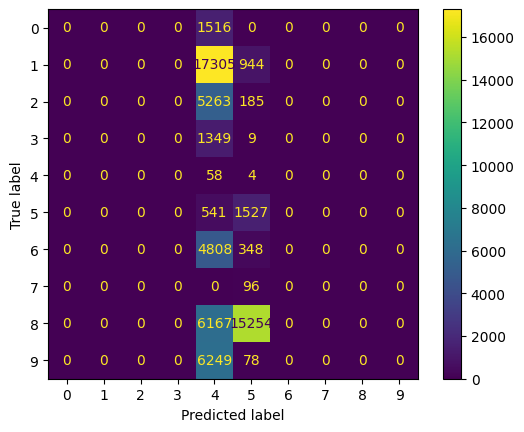

In [ ]:
if ml:
    classes = best_clf.classes_
    
    if overfit:
        y_pred = best_clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot()
        print(classification_report(y_test, y_pred))
    else:
        y_pred = best_clf.predict(X_val)
        cm = confusion_matrix(y_val, y_pred, labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot()
        print(classification_report(y_val, y_pred))

else:
    if clf == 'ffnn':
        # Evaluate the best model on the test set
        test_loader = DataLoader(test_dataset, batch_size=batch_sizes[0])

        model.to(device)
        model.eval()
        y_test, y_pred_c, y_pred = test_model(model, test_loader, device)

    elif clf == 'tabtransf':
        test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0], shuffle=False)

        _, y_pred, y_true = test_model(model, criterion, test_loader)
        y_pred_c = y_pred.argmax(dim=1, keepdim=True).squeeze()

    elif clf == 'tabnet':
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=y_test.max().item() + 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.max().item() + 1)
        disp.plot()
        print(classification_report(y_test, y_pred))

    if clf != 'tabnet':
        # Print Accuracy, Precision, F1 Score and Confusion Matrix
        print(f"Accuracy: {:.4f} --\t Precision: {:.4f} --\t F1: {:.4f} --\t Balanced Accuracy: {:.4f}".format( 
            tm.MulticlassAccuracy().update(y_pred_c, y_test).compute().item(), 
            tm.MulticlassPrecision(num_classes=y_test.max().item() + 1).update(y_pred, y_test).compute().item(),
            tm.MulticlassF1Score(num_classes=y_test.max().item() + 1, ).update(y_pred, y_test),
            balanced_accuracy_score(y_test.cpu().numpy(), y_pred_c.cpu().numpy())))

        print(classification_report(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))
        conf_matrix = tm.MulticlassConfusionMatrix(num_classes=y_test.max().item() + 1)
        conf_matrix.update(y_pred_c, y_test)
        ConfusionMatrixDisplay(conf_matrix.compute().cpu().numpy()).plot()
